In [1]:
import tensorflow as tf
%matplotlib notebook
%matplotlib inline
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import cv2
import datetime
import random
from tensorflow.keras.layers import Dense, GRU, TimeDistributed

from IPython import display

import seaborn as sns
from tqdm.notebook import tqdm, trange
sns.set()
tf.keras.backend.floatx()

latent_dim = 50

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

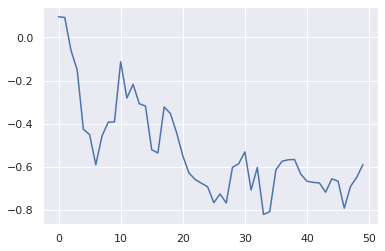

In [3]:
def get_batch(batch_size):
    x = np.random.normal(size=[batch_size, 50], scale=0.1)
    x = np.cumsum(x, axis=1)
    return x

plt.plot(np.arange(50), get_batch(1)[0])

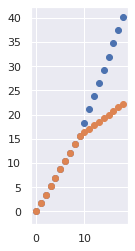

In [50]:
n = 10
k = (np.random.rand() - 0.5) * 4
y = np.arange(n) * k
y1 = y[-1] + np.arange(n) * (k + 1)
y2 = y[-1] + np.arange(n) * (k - 1)
y1 = np.concatenate([y[:-1], y1])
y2 = np.concatenate([y[:-1], y2])

plt.scatter(np.arange(n * 2 - 1), y1)
plt.scatter(np.arange(n * 2 - 1), y2)

plt.gca().set_aspect('equal')

In [3]:
class MDN_RNN(tf.keras.Model):
    def __init__(self, n_mixtures, out_dims):
        super(MDN, self).__init__()
        
        self.n_mixtures = n_mixtures
        self.out_dims = out_dims
        self.fc1 = TimeDistributed(Dense(128, activation='tanh'))
        self.gru = GRU(128)
        self.fc2 = Dense(3 * n_mixtures * out_dims, activation='tanh')

    def predict_distribution(self, x):
        ''' 
            x.shape = [batch_size, seq_length, latent_dim]
        '''
        x = self.fc1(x)
        x = self.gru(x)
        x = self.fc2(x)
        mean, log_std, alpha = tf.split(x, 3, axis=1)
        
        mean = tf.reshape(mean, [-1, self.n_mixtures])
        log_std = tf.reshape(log_std, [-1, self.n_mixtures])
        alpha = tf.reshape(alpha, [-1, self.n_mixtures])
        alpha = tf.nn.softmax(alpha, axis=1)

        return mean, log_std, alpha
    
    def sample(self, x, temperature=1.0, verbose=False):
        # Predicting distribution
        mean, log_std, alpha = self.predict_distribution(x)
        std = tf.exp(log_std) * np.sqrt(temperature)
#         print(alpha)
#         alpha = alpha / temperature
#         alpha -= tf.reduce_max(alpha)
#         alpha = tf.nn.softmax(alpha, axis=-1)
#         print(alpha)
        
        
        # Picking component
        rnd = tf.random.uniform(shape=[x.shape[0] * self.out_dims, 1], maxval=1)
        rnd = tf.repeat(rnd, self.n_mixtures, axis=-1)
        pdf = tf.cumsum(alpha, axis=-1)
        component_idx = np.argmax(pdf > rnd, axis=-1)
        
        # Gathering std and mean
        idx_flattened = tf.range(0, mean.shape[0]) * mean.shape[1] + component_idx
        component_std = tf.gather(tf.reshape(std, [-1]), idx_flattened)
        component_mean = tf.gather(tf.reshape(mean, [-1]), idx_flattened)

        # Sampling
        samples = tf.random.normal(shape=[x.shape[0] * self.out_dims])
        samples = samples * component_std + component_mean
        samples = tf.reshape(samples, [-1, self.out_dims])
        
        return samples
    
    def call(self, x):
        return self.sample(x)

In [52]:
model = tf.keras.Sequential(layers=[
    GRU(64),
    Dense(64),
    Dense(64),
])
model.compile(optimizer='adam', loss='mse')

In [58]:
x = np.arange(100)
y = x[np.newaxis, 1:, np.newaxis]
x = x[np.newaxis, :-1, np.newaxis]

In [59]:
model.fit(x,  batch_size=32, epochs=10)

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 3s 3s/sample


TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type int64 of argument 'a'.